<a href="https://colab.research.google.com/github/AxelBattut/BinanceAPI/blob/main/TwitterDyor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notre objectif initial est de développer un bot de trading en y implémentant une analyse technique (fournie par un bot sur twitter ainsi que notre propre calcul, à voir plus tard) et une analyse de tendance (de la même manière fournie par un bot sur twitter et ajustée avec nos paramètres).


Nous commencons donc par installer les librairies dont nous avons besoin, cad les libraires twitter, binance, requests (pour utiliser des get sur coingecko) textblob pour des utilisations de graphiques.

In [ ]:
!pip install twitter
!pip install requests
!pip install python-binance
!pip install tweepy
!pip install textblob
!pip install pycoingecko


Notre objectif initial est de récupérer les informations données par @DYORCryptoBot. Ce bot sur twitter est un bot non-open source qui s'appuie (selon sa doc) sur ses propres indicateurs techniques et de tendance pour proposer 5 tokens bullish et 5 tokens en tendance renversement bullish (etaient bearish, ont un potentiel bullish) toutes les 15 minutes. Un token se dit bullish s'il voit son cours être apprécié (positif). Un token se dit bearish s'il voit son cours être déprécié (négatif). Nous partons de l'hypothèse que ces résultats sont cohérents et nous verrons plus tard comment nous allons confirmer ou infirmer ces tendances. Nous avons délibérement fait le choix de ne pas faire notre propre analyse de tous les tokens listés sur une plateforme étant donné que l'api de twitter accepte un nombre de requêtes limitées tout comme binance. On a donc dans ce cas un problème : 
1. de nombre de requêtes trop multiples
2. de traitement d'un trop grand nombre de données donc d'une attente trop longue pour obtenir des résultats et "timer" notre trading sur les coins en question.

En résumé, nous allons acheter des tokens qui nous sont indiqués comme bullish par notre bot, nous allons les revendre en espèrant avoir fait un profit, et nous allons répéter cette manoeuvre indéfiniment (toutes les 15 minutes en question).

Juste avant de rentrer dans le dur du sujet, faisons un exemple de ce qui peut être fait avec l'API de Twitter. On déclare d'abord notre API.

In [ ]:
import tweepy 
import pandas as pd


consumer_key = "xxx"
consumer_secret = "xxx"
access_token = "xxx"
access_token_secret = "xxx"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

Si vous voulez pouvoir run vous même ces lignes, vous avez besoin d'avoir créer une API Twitter, pour ce faire vous pouvez vous rendre sur https://developer.twitter.com/apps et cliquer sur le bouton "Create an app". Vous obtiendrez ensuite vos keys que vous pouvez renseigner juste en haut.

On peut ensuite utiliser l'API de twitter pour toute sorte de requêtes, ici on voit que l'on peut retourner le texte du dernier tweet du compte @0xJokeIsHere

In [ ]:
cursor = tweepy.Cursor(api.user_timeline, id='0xJokeIsHere', tweet_mode="extended").items(1)
for i in cursor:
  #print(dir(i))
  print(i.full_text)

@Apedignio Évitez @crypto_futur @CryptoMatrix2 vous êtes débutants, vous gagnerez du temps


Fini la démonstration, on peut maintenant commencer à s'intéresser à notre cas d'étude. On importe ici toutes les librairies que l'on utilisera par la suite et on redéclare notre API.

In [ ]:
import tweepy 
import pandas as pd
import csv
from datetime import datetime
from datetime import date, timedelta
import numpy as np
import requests
import json
from textblob import TextBlob


#Renseignez vos keys ici
consumer_key = "ovAUJWFp4AkjlSHMviEPTCvnp"
consumer_secret = "KhRaRsRBzRYhkjgbS9yCA7EMHKn1g3xLUQiNkDkR173deMGVIl"
access_token = "1343316681695895552-jOOG8ZYWod4DBPxclsgQfXZ5oP8vTO"
access_token_secret = "lr5l1TK3VelIlYXJVBsy9mlB9qo6yOXOMtq6MyYqQ20H1"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)
#api = tweepy.API(auth, wait_on_rate_limit=True)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True) #pour empecher que l'erreur 429 se produise, attention ce n'est pas optimal, le programme va simplement se lancer lorsque mon api aura des crédits donc autant limiter directement son nombre de requetes

On récupère donc les 15 derniers tweets du bot twitter. Pourquoi ca ? Je vous rappelle que notre objectif est d'acheter les tokens proposés par le bot de twitter de les revendre au bout de 15 minutes et d'acheter la nouvelle liste proposée.

In [ ]:



number_of_tweets = 15 
#attention, ici on peut etre tenté d'en mettre un seul parce que l'on veut accèder
# seulement à un seul tweet (binance usdt pair) mais cela ne veut pas dire que ce tweet est forcement celui souhaité
#on en prend donc 15 pour se hedge
tweets = []
likes = []
time=[]

for i in tweepy.Cursor(api.user_timeline, id="DYORCryptoBot", tweet_mode="extended").items(number_of_tweets):
  tweets.append(i.full_text)
  likes.append(i.favorite_count)
  time.append(i.created_at)
  

df = pd.DataFrame({'tweets':tweets, 'likes':likes, 'time':time})

#Voila l'utilité d'avoir récupéré 15 tweets, ici nous supprimons tous les tweets qui concernent des tendances bullish sur des
#plateformes différents de binance et sur une paire différente que USDT
df = df[~df.tweets.str.contains("FTX")]
df = df[~df.tweets.str.contains("KuCoin")]
df = df[~df.tweets.str.contains("#BTC")]
df = df[~df.tweets.str.contains("#Bitcoin")]
df = df[~df.tweets.str.contains("4h")]
df = df.reset_index(drop=True)

df






,tweets,likes,time
0,[SCAN RESULTS - 15m - #USDT PAIR]\n\nExchange:...,0,2022-01-07 12:15:59
1,[SCAN RESULTS - 15m - #USDT PAIR]\n\nExchange:...,1,2022-01-07 11:45:59


On a donc récupéré 2 tweets correspondant à notre recherche. On ne se servira que du dernier. On en profite pour afficher le tweet le plus liké.

In [ ]:
mostlike =df.loc[df.likes.nlargest(5).index]
mostlike

,tweets,likes,time
1,[SCAN RESULTS - 15m - #USDT PAIR]\n\nExchange:...,1,2022-01-07 11:45:59
0,[SCAN RESULTS - 15m - #USDT PAIR]\n\nExchange:...,0,2022-01-07 12:15:59


On récupère maintenant les assets mentionnés dans la liste results

In [ ]:
import re 
line_of_sentences = [sentence for sentence in df.tweets]

lines = []
for sentence in line_of_sentences:
  words =sentence.split()
  for w in words:
    lines.append(w)
#j'ai split mes elements de df en une liste de words 
#print(lines[1:])
results = []
for element in lines:
    for x in element:
        if x == '$':
            x =  element.index('$')
            results.append(element[x+1:])
results
#results est bel et bien la liste de mot que pourrai utiliser par la suite (pour index pas tant que ca mais surtout pour mon csv a renseigner pour binance)

['FXS',
 'C98',
 'IRIS',
 'ATOM',
 'ONE',
 'REQ',
 'ZRX',
 'XTZ',
 'LIT',
 'DYDX',
 'UTK',
 'ATOM',
 'FXS',
 'ONE',
 'IRIS',
 'PAXG',
 'IRIS',
 'NMR',
 'KP3R',
 'PORTO']

On a maintenant une liste de tous les tokens mentionnés. On utilisera uniquement les 10 derniers car ce sont les 10 mentionnés dans le dernier tweet.

Un peu de ML maintenant, on cherche maintenant à partir de nos tokens à savoir lequel est le plus mentionné sur twitter dans les derniers moments. On associera alors un index de tendance sur chacun des tokens en fonction de leur nombre d'apparitions respectives.
En résultat on affiche respectivement le nombre d'apparition respective, le token en question, le pourcentage d'apparition global.

In [ ]:

nombre_apparition_token = []
tokens = []
entropytoken = []
for w in range(10):

  number_of_tweets = 40 
  tweets = []
  likes = []
  time=[]

  for i in tweepy.Cursor(api.search, q=results[w], tweet_mode="extended").items(number_of_tweets):
    tweets.append(i.full_text)
    likes.append(i.favorite_count)
    time.append(i.created_at)



  df = pd.DataFrame({'tweets':tweets, 'likes':likes, 'time':time})

  now = datetime.now()

  #yesterday = now - datetime.timedelta(days=1)

  dt_string = (now- timedelta(0.002)).strftime("%Y-%m-%d %H:%M:%S") #0.04 = 1h
  #print("date and time =", dt_string)
  df = df[~(df['time'] < dt_string)]

  df = df[~df.tweets.str.contains("RT")]
  df = df.reset_index(drop=True)

  #df

  #total_rows = df.count
  #print(total_rows)
  #print(len(df.index))

  nombre_apparition_token.append(len(df.index))
  tokens.append(results[w])


print(nombre_apparition_token)
print(tokens)


somme_apparition_tokens = 0
for f in range(9):
  somme_apparition_tokens = somme_apparition_tokens + nombre_apparition_token[f]

print("Les 10 assets ont été mentionnés un total de ", somme_apparition_tokens)

for h in range(10):
  nb_non_weighted = nombre_apparition_token[h] / somme_apparition_tokens
  entropytoken.append(nb_non_weighted)
print(entropytoken)






[1, 0, 32, 15, 12, 33, 0, 11, 21, 1]
['FXS', 'C98', 'IRIS', 'ATOM', 'ONE', 'REQ', 'ZRX', 'XTZ', 'LIT', 'DYDX']
Les 10 assets ont été mentionnés un total de  125
[0.008, 0.0, 0.256, 0.12, 0.096, 0.264, 0.0, 0.088, 0.168, 0.008]


Ici notre majeur problème a été l'erreur 429, trop de requêtes pour l'api. Le contourner ? Faire un echantillon sur une période plus courte : 3 minutes et rechercher moins de tweets maximum : 100. Pb : peut etre moins représentatif de la tendance generale. Pour autant le plus important est d'avoir un bot fonctionnel 24/24 donc concession prise

On souhaite maintenant créer un index pour chaque token. On va tout simplement normaliser son pourcentage d'apparition pour que le coefficient multiplicateur soit compris entre 0,5 et 1.5 (choisi arbitrairement). Liste en question : entropytoken_around_one

In [ ]:
entropytoken_around_one = []
for u in range(len(entropytoken)):
  entropytoken_around_one.append( (entropytoken[u] - np.min(entropytoken)) / (np.max(entropytoken) - np.min(entropytoken)) + 0.5) #on a centré nos valeurs entre 0.5 et 1.5

print(entropytoken_around_one)
for y in range(len(entropytoken_around_one)):
  if(entropytoken_around_one[y] <1):
    entropytoken_around_one[y] = entropytoken_around_one[y] + entropytoken_around_one[y] * 0.2
  else:
    entropytoken_around_one[y] = entropytoken_around_one[y] - entropytoken_around_one[y] * 0.2

#on a davantage centré nos valeurs autour de 1
print(entropytoken_around_one)

#moyenne = np.mean(entropytoken)
#def NormalizeData(data):
#    return (data - np.min(data)) / (np.max(data) - np.min(data))

[0.5303030303030303, 0.5, 1.4696969696969697, 0.9545454545454546, 0.8636363636363636, 1.5, 0.5, 0.8333333333333333, 1.1363636363636362, 0.5303030303030303]
[0.6363636363636364, 0.6, 1.1757575757575758, 1.1454545454545455, 1.0363636363636364, 1.2, 0.6, 0.9999999999999999, 0.909090909090909, 0.6363636363636364]


On visualise nos données 

In [ ]:
import plotly.express as px
import numpy
 
fig = px.pie(values=nombre_apparition_token, names=tokens, color_discrete_sequence=px.colors.sequential.RdBu, title="Répartition du nombre de tweets citant un token dans les dernières 3 minutes")
fig.show()

On en profite pour faire un cas d'étude du top 3 des plus mentionnées de ces cryptos depuis 300j en résumant l'appréciation du token dans un graphique. 

['req', 'iris', 'lit']
['request-network', 'iris-network', 'litentry']
[               request-network
1615680000000         0.115487
1615766400000         0.114584
1615852800000         0.121422
1615939200000         0.123575
1616025600000         0.148154
...                        ...
1641254400000         0.370057
1641340800000         0.359523
1641427200000         0.326624
1641513600000         0.319080
1641577105000         0.302614

[301 rows x 1 columns],                iris-network
1615680000000      0.175500
1615766400000      0.167065
1615852800000      0.196324
1615939200000      0.213839
1616025600000      0.239662
...                     ...
1641254400000      0.091272
1641340800000      0.095373
1641427200000      0.086571
1641513600000      0.085807
1641577119000      0.137154

[301 rows x 1 columns],                 litentry
1615680000000   9.949856
1615766400000  11.222526
1615852800000  10.342591
1615939200000  11.487363
1616025600000  10.882027
...                 

,datetime,date,hour,currency_name,value
0,2021-03-14,2021-03-14,0,request-network,0.115487
1,2021-03-15,2021-03-15,0,request-network,0.114584
2,2021-03-16,2021-03-16,0,request-network,0.121422
3,2021-03-17,2021-03-17,0,request-network,0.123575
4,2021-03-18,2021-03-18,0,request-network,0.148154
...,...,...,...,...,...
899,2022-01-01,2022-01-01,0,litentry,2.962963
900,2022-01-02,2022-01-02,0,litentry,3.116728
901,2022-01-03,2022-01-03,0,litentry,3.186888
902,2022-01-04,2022-01-04,0,litentry,3.101675


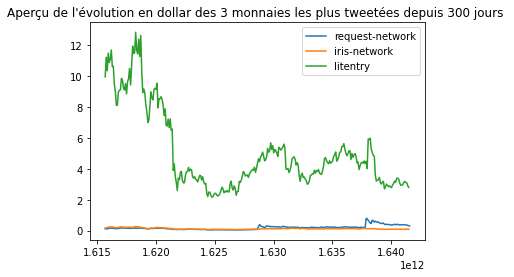

In [ ]:

from pycoingecko import CoinGeckoAPI

#On récupère notre les 3 tokens les plus cités

dict_from_list = dict(zip(tokens, nombre_apparition_token)) #On crée un dictionnaire avec les tokens comme clés, et le nombra d'apparition du token pour valeur
dict_tokens=sorted(dict_from_list.items(), key=lambda t: t[1], reverse=True) #On trie notre dictionnaire par ordre decroissant
lst=dict_tokens[:3] 
keys = [*dict(lst)]
keys

list = []
for i in keys:

  list.append(i.lower())

print(list) #On passe la liste en minuscule

#Sur CoinGecko chaque token a un ID bien specifique l'acronyme en majuscule n'est donc pas reconnue, 
#on replace donc les tokens de notre liste par leur ID equivalent dans l'API CoinGecko
gecko_list = []
for l in list :
    for token in retour:
        if token["symbol"] == l:
            l = token['id']
            gecko_list.append(l)

print(gecko_list)

#On affiche alors l'evolution du prix en dollar 3 tokens selectionnés sur les derniers 300 jours
cg = CoinGeckoAPI()
timePeriod = 300

data = {}
for coin in gecko_list:
    try:
        nested_lists = cg.get_coin_market_chart_by_id(
            id=coin, vs_currency="usd", days=timePeriod
        )["prices"]
        data[coin] = {}
        data[coin]["timestamps"], data[coin]["values"] = zip(*nested_lists)

    except Exception as e:
        print(e)
        print("coin: " + coin)

historique = [
    pd.DataFrame(data[coin]["values"], index=data[coin]["timestamps"], columns=[coin])
    for coin in gecko_list
    if coin in data
]
print(historique)

df_cryptocurrency = pd.concat(historique, axis=1).sort_index()
df_cryptocurrency.plot(title="Aperçu de l'évolution en dollar des 3 monnaies les plus tweetées depuis 300 jours ")

df_cryptocurrency["datetime"] = pd.to_datetime(df_cryptocurrency.index, unit="ms")
df_cryptocurrency["date"] = df_cryptocurrency["datetime"].dt.date
df_cryptocurrency["hour"] = df_cryptocurrency["datetime"].dt.hour

df_cryptocurrency = df_cryptocurrency.melt(
    id_vars=["datetime", "date", "hour"], var_name="currency_name"
)
df_cryptocurrency.head(-5)

Maintenant que l'on a un index correspondant à une performance d'apparition dans twitter, on veut s'assurer que cette tendance est positive. Pour ce faire on utilise la bibliothèque TextBlob qui, à partir d'un texte définit si ce texte est plutot positif ou négatif.

In [ ]:
def get_related_tweets(key_word):
    twitter_users = []
    tweet_time = []
    tweet_string = [] 
    for tweet in tweepy.Cursor(api.search,q=key_word, count=100).items(100):
            if (not tweet.retweeted) and ('RT @' not in tweet.text):
                if tweet.lang == "en":
                    twitter_users.append(tweet.user.name)
                    tweet_time.append(tweet.created_at)
                    tweet_string.append(tweet.text)
                    #print([tweet.user.name,tweet.created_at,tweet.text])
    df = pd.DataFrame({'name':twitter_users, 'time': tweet_time, 'tweet': tweet_string})
    
    return df

#get_related_tweets("Dragon")

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt
def get_sentiment(key_word):
    df = get_related_tweets(key_word)
    df['sentiment'] = df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
    df_pos = df[df['sentiment'] > 0.0]
    df_neg = df[df['sentiment'] < 0.0]
    
    print("Number of Positive Tweets about {}".format(key_word), len(df_pos))
    print("Number of Negative Tweets about {}".format(key_word), len(df_neg))
    sns.set()
    labels = ['Positive', 'Negative']
    heights = [len(df_pos), len(df_neg)]
    for i in range(10):
      plt.subplot(2, 1, i) 
      plt.bar(labels, heights, color = 'navy')
      plt.title(key_word)
      return (len(df_pos)/(len(df_neg)+1))
    

#get_sentiment("$BTC")
#return (len(df_pos)/len(df_neg))
list_index_humeur_asset = []

for i in range(10):
  list_index_humeur_asset.append(get_sentiment(results[i]))



Number of Positive Tweets about FXS 16
Number of Negative Tweets about FXS 4


ValueError: ignored

<Figure size 432x288 with 0 Axes>

On affiche le graphe de dernier token mentionné, juste pour avoir une représentation graphique

On a finalement récupéré dans notre liste "list_index_humeur_asset" le rapport positif/negatif qui nous retourne un second indice de performance.


In [ ]:
print(list_index_humeur_asset)

[10.666666666666666, 3.5, 1.3333333333333333, 5.5, 3.3333333333333335, 1.6666666666666667, 0.8333333333333334, 9.666666666666666, 4.0, 0.8]


Et je rappelle que l'on a aussi notre index de performance en fonction du nombre d'appartion du token sur twitter ((entropytoken_around_one).

In [ ]:
print(entropytoken_around_one)

[0.6363636363636364, 0.6, 1.1757575757575758, 1.1454545454545455, 1.0363636363636364, 1.2, 0.6, 0.9999999999999999, 0.909090909090909, 0.6363636363636364]


On en a finir pour la partie twitter. On recupere maintenant le prix actuel de notre asset pour savoir combien de cet asset va t'on acheter (attention de bien avoir un nombre rond). Pour ce faire on fait appel à l'api de coingecko qui nous retourne le prix d'un asset à un moment donné. Problème il faut renseigner le nom du token et non pas le symbole donc je dois d'abord associer le symbole au nom en faisant un premier appel sur coingecko. On obtient alors notre liste "nb_assets_achat" qui correspond au nombre de tokens respectifs que l'on va acheter pour chaque token. On a pris dans cet exemple qu'on allait acheter 20 USD de chaque token (minimum 10.3 USD pour un ordre d'achat sur binance).

In [ ]:
import requests

r = requests.get("https://api.coingecko.com/api/v3/coins/list")
retour = r.json()
list1 =["btc","eth","link","bch","vet","ada","strax","ada","mbl",'gxs']
list2 = results[:10]

list = []
for i in list2:

  list.append(i.lower())

print(list)

listId=[]
for l in list :
    for token in retour:
        if token["symbol"] == l:
            l = token['id']
            listId.append(l)

print(listId)
base_url = "https://api.coingecko.com/api/v3"
liste_prix_assets = []
for u in listId:

  url = base_url + f"/simple/price?ids={u}&vs_currencies=usd"
  r = requests.get(url)
  #print(r.json())
  #print(r.json()[ids]['usd']) #on affiche sa valeur 
  liste_prix_assets.append(r.json()[u]['usd'])

print(liste_prix_assets)




nb_assets_achat = []
for d in liste_prix_assets:
  nb_assets_achat.append(20/d) #on allocate 20 usd pour chacun des 10 tokens

#print(nb_assets_achat)







['fxs', 'c98', 'iris', 'atom', 'one', 'req', 'zrx', 'xtz', 'lit', 'dydx']
['frax-share', 'coin98', 'iris-network', 'cosmos', 'harmony', 'request-network', '0x', 'tezos', 'litentry', 'dydx']
[37.99, 2.51, 0.120789, 43.57, 0.318749, 0.301463, 0.740034, 4.24, 2.6, 7.06]


Pour autant, nous allons modifier cette quantité de 20 USD puisque nous avons justement défini des indexs de performance pour optimiser nos investissements en fonction de nos indices.

In [ ]:
nb_assets_achat_weighted = []
for i in range(len(nb_assets_achat)):
  nbr = nb_assets_achat[i] * 0.4 * list_index_humeur_asset[i]  *entropytoken_around_one[i]
  nb_assets_achat_weighted.append(nbr)

print(nb_assets_achat)
print(nb_assets_achat_weighted)

[0.5264543300868649, 7.9681274900398416, 165.57799137338665, 0.4590314436538903, 62.74529488719965, 66.34313331984357, 27.025785301756407, 4.716981132075471, 7.692307692307692, 2.8328611898017]
[1.429403271993427, 6.693227091633467, 103.829108125857, 1.1567592380078038, 86.70258929867589, 53.07450665587486, 5.405157060351282, 18.23899371069182, 11.188811188811187, 0.5768735513778008]


Vous voyez que cette fois-ci on obtient une liste avec un nombre d'assets différents à acheter, ce nombre d'assets correspond au nombre optimal defini en fonction de nos indexs de tendance.

On peut maintenant renseigner l'ensemble des informations (le token à acheter et le nombre d'assets de ce token à acheter) dont on avait besoin pour faire fonctionner notre bot de trading sur binance dans un fichier csv.

In [ ]:

#ON ECRIT DANS NOTRE FICHIER CSV
quantite_calculee = nb_assets_achat_weighted
#quantite_calculee = retour_nb_assets_achat()
#print(quantite_calculee)

file = open("position.csv", "w")
writer = csv.writer(file)


token = []
usdtpair = "USDT"
lastlistedtokens = results[:10] #nos 20 derniers resultats ouai on prend du large
for x in range(len(lastlistedtokens)):
  token.append(lastlistedtokens[x] + 'USDT') #on cree la paire qui doit etre respectee

position = [0,0,0,0,0,0,0,0,0,0]
quantite = []
for c in quantite_calculee:
  quantite.append(round(c, 8))

print(quantite)

colonne3 = ['quantity']
colonne2 = ['position']
colonne1 = ['Currency']
for w in range(1):
  writer.writerow([colonne1[w], colonne2[w],colonne3[w]])
  #writer.writerow(['Currency'],['position'],['quantity'])
#print(len(token))
#print(len(position))
#print(len(quantite))
for w in range(len(token)):
  
  writer.writerow([token[w], position[w],round(quantite[w], 3)]) #on remplit direct le doc

file.close()

[1.42940327, 6.69322709, 103.82910813, 1.15675924, 86.7025893, 53.07450666, 5.40515706, 18.23899371, 11.18881119, 0.57687355]


On peut maintenant passer à l'implémentation de notre bot binance qui nous permettra de market buy et market sell les tokens souhaités automatiquement. 
Pour ce faire, nous devons créer une API Binance, vous pouvez vous créer un compte et une API dans Profil->Gestion API et modifier les restrictions en cliquant sur "Activer le trading au comptant et sur marge". Attention, ces clés sont privées, ne les partagez à personne.

In [ ]:
from binance.client import Client
import pandas as pd
client = Client('xxx','xxx')

In [ ]:
import pandas as pd
from google.colab import files
#uploaded = files.upload()
import io
#posframe = pd.read_csv(io.BytesIO(uploaded['position.csv']))

posframe = pd.read_csv('position.csv')


#posframe = pd.read_csv('position')
posframe

,Currency,position,quantity
0,FXSUSDT,0,0.528
1,C98USDT,0,8.163
2,IRISUSDT,0,192.829
3,ATOMUSDT,0,0.472
4,ONEUSDT,0,63.821
5,REQUSDT,0,65.662
6,ZRXUSDT,0,27.125
7,XTZUSDT,0,4.773
8,LITUSDT,0,7.722


On a affiché notre fichier avec la bibliotheque panda. Vous remarquez que l'on utilise une colonne position. Elle sert en cas de récurrence d'un token. Le 0 devient un 1 si l'on a market buy la paire à l'aide de la fonction ci-dessous.

In [ ]:
def changepos(curr, buy=True):
  if buy:
    posframe.loc[posframe.Currency == curr, 'position'] =1 #positionnement achat ou non
  else:
    posframe.loc[posframe.Currency == curr, 'position'] =0

  posframe.to_csv('position', index=False) #tjrs actualiser notre dataset en mettant l'index comme une non colonne

On récupére les données utile d'un token a l'aide de la fonction ci-dessous

In [ ]:
def gethourlydata(symbol):
  #klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")
  #framebis = client.get_historical_klines(symbol, '1 hour ago UTC', '25 hours ago UTC')
  frame = pd.DataFrame(client.get_historical_klines(symbol, '1h', '25 hours ago UTC')) #1h for the fast sma, 25h for the slow sma

  frame =frame.iloc[:,:5] #only the five first columns
  frame.columns = ['Time','Open','High','Low','Close'] #rename it
  frame[['Open','High','Low','Close']] = frame[['Open','High','Low','Close']].astype(float)
  frame.Time = pd.to_datetime(frame.Time, unit='ms')

  return frame

On définit maintenant les valeurs de Fast Moving Average et de Slow Moving Average.

In [ ]:
df = gethourlydata("BTCUSDT")

def applytechnicals(df): #on cherche a savoir si Fastsma 
  df['FastSMA'] = df.Close.rolling(7).mean()
  df['SlowSMA'] = df.Close.rolling(25).mean() #25 timesteps

applytechnicals(df)
df


,Time,Open,High,Low,Close,FastSMA,SlowSMA
0,2022-01-06 12:00:00,42878.33,43077.00,42632.44,43062.76,NaN,NaN
1,2022-01-06 13:00:00,43062.77,43200.00,42900.00,43150.01,NaN,NaN
2,2022-01-06 14:00:00,43150.00,43267.09,42761.90,42805.50,NaN,NaN
3,2022-01-06 15:00:00,42805.50,43019.71,42666.00,42950.01,NaN,NaN
4,2022-01-06 16:00:00,42950.02,43131.76,42725.09,42882.22,NaN,NaN
5,2022-01-06 17:00:00,42882.23,43175.66,42790.89,43005.29,NaN,NaN
6,2022-01-06 18:00:00,43005.30,43400.00,42982.05,43369.04,43032.118571,NaN
7,2022-01-06 19:00:00,43369.04,43508.78,43224.73,43438.10,43085.738571,NaN
8,2022-01-06 20:00:00,43438.11,43581.30,43111.57,43221.50,43095.951429,NaN
9,2022-01-06 21:00:00,43221.50,43253.29,43066.04,43120.64,43140.971429,NaN


On rentre maintenant concrètement dans le coeur de notre fonction. L'indicateur technique est le suivant : si la fastSMA > à la slowSMA, alors on a un indicateur technique bullish et on confirme que l'on veut market buy l'asset. Si ce n'est pas le cas, on ne fait rien. 
Si on a déjà acheté l'asset, alors on le market sell tout simplement.

In [ ]:
def trader(curr):
  firstqty = posframe[posframe.Currency == curr].quantity.values[0] #on va selectionner la valeur que l'on veut investir 
  #qty = float(round(firstqty, 6))
  #print(qty)


  df = gethourlydata(curr)
  applytechnicals(df)
  lastrow = df.iloc[-1] #on ne s'interesse qu'a la last row
  if not posframe[posframe.Currency == curr].position.values[0]: #si l'on est pas en position
    if lastrow.FastSMA < lastrow.SlowSMA:
      print(round(firstqty,0))
      order = client.create_order(symbol=curr,side='BUY',type='MARKET',quantity= (round(firstqty,0)))

      print(order)
      changepos(curr, buy=True)
     
    else:
      print(f'Not in position {curr} but condition not fulfilled')
  else: #si l'on est deja en position
    print(f'Already in {curr} position')
    if lastrow.SlowSMA > lastrow.FastSMA:
      print(round(firstqty,6))
      order = client.create_order(symbol=curr,side='SELL',type='MARKET',quantity= (round(firstqty,6)))

      print(order)
      changepos(curr, buy=False)



Il nous reste plus qu'à lancer notre fonction pour chaque token que l'on va potentiellement market buy ou market sell. 
Vous pouvez voir que certains orders sont 'FILLED'. Cela veut bel et bien dire que l'ordre est passé sur binance. Mission réussie.

In [ ]:
for coin in posframe.Currency:
  trader(coin)

Not in position FXSUSDT but condition not fulfilled
Not in position C98USDT but condition not fulfilled
Not in position IRISUSDT but condition not fulfilled
Not in position ATOMUSDT but condition not fulfilled
Not in position ONEUSDT but condition not fulfilled
65.0
{'symbol': 'REQUSDT', 'orderId': 51518223, 'orderListId': -1, 'clientOrderId': 'JWuqH3IigMoyRK50cqMzNV', 'transactTime': 1641563233131, 'price': '0.00000000', 'origQty': '65.00000000', 'executedQty': '65.00000000', 'cummulativeQuoteQty': '19.89650000', 'status': 'FILLED', 'timeInForce': 'GTC', 'type': 'MARKET', 'side': 'BUY', 'fills': [{'price': '0.30610000', 'qty': '65.00000000', 'commission': '0.06500000', 'commissionAsset': 'REQ', 'tradeId': 10129535}]}
26.0
{'symbol': 'ZRXUSDT', 'orderId': 492161987, 'orderListId': -1, 'clientOrderId': 'qPM7ss91RAoq3yI5YRMS0Z', 'transactTime': 1641563233945, 'price': '0.00000000', 'origQty': '26.00000000', 'executedQty': '26.00000000', 'cummulativeQuoteQty': '19.07620000', 'status': 'FI

CONCLUSION : Nous avons réussi à nous appuyer sur un indicateur de tokens étant bullish sur twitter et à confirmer ou infirmer ces tendances de marché en lui apposant un index de confiance (nb d'apparition, positivité ou negativité). Nous avons ensuite pu utiliser l'api de coingecko pour récupérer des données utiles sur les tokens en question. Nous avons ensuite utilisé l'api de binance pour market sell et/ou market buy les tokens sélectionnés en fonction de notre propre indicateur technique. 

Perspectives d'évolution :

*   Côté technique : Il me faut implémenter un Index historique, cad créer un index qui recense les performances passées de chaque token cité sur le bot twitter et assigne un index en fonction de son côté 'gainer' ou non.
*   Côté tendance : Il me faut ajuster le coeff attribué à chacun des indexs pour optimiser historiquement le rendement en fonction des paramètres de tendance. Je voudrais aussi implémenter un autre index qui se fie a la capitalisation en question du token et qui donc attribue un index plus haut à une petite capitalisation (car plus gros potentiel de faire des grosses bougies).

*   Côté implémentation : La version qui vous est présentée est une version fonctionnelle. Cependant elle n'est pas optimale car il faut relancer l'algo toutes les 15 minutes. Pour que l'algo soit réellement un bot sans aide exterieure, il faut que je réagence mon code et que je lie chacun des blocs que je peux appeler en une seule commande. Et j'appellerai ensuite cette commande toutes les 15 minutes (ou dès qu'un nouveau tweet du 

Merci de nous avoir lu. 
Travail réalisé par Ines Guitton et Axel Battut. 







